In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
from sklearn.linear_model import SGDRegressor
import time
from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import root_mean_squared_error

# Define the list of top 100 company tickers, use only AAPL for now
tickers = ['AAPL']

# Set the date range
start_date = '1994-11-06'
end_date = datetime.today().strftime('%Y-%m-%d')

# Loop through each ticker and download data
for ticker in tickers:
    # Download historical data
    data = yf.download(ticker, start=start_date, end=end_date)
    # Reset column names to avoid mismatched headers
    data.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    # Reset the index to a new "Date" column and keep only the date part
    data.reset_index(inplace=True)
    data['Date'] = data['Date'].dt.date  # Convert DateTime to just date (YYYY-MM-DD format) to get rid of hours, minutes, and seconds
    data['Date'] = pd.to_datetime(data['Date']) # Convert 'Date' column to datetime format so model interpret it as dates
   

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")


# Separate the 'Date' column (to keep it unchanged)
date_column = data['Date']
data_numeric = data.drop(columns=['Date'])

# Apply standardization
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data_numeric)

# Convert standardized data back to a DataFrame with original column names
standardized_df = pd.DataFrame(data_standardized, columns=data_numeric.columns)

# Add the 'Date' column back to the standardized DataFrame
standardized_df.insert(0, 'Date', date_column)
Apple = standardized_df


# initial training sample
init = 3000


X = Apple.loc[0:init, ['Adj Close','Open', 'High', 'Low', 'Volume']]
y = Apple.loc[0:init, ['Close']]
SGD = SGDRegressor(warm_start=True, penalty='l2')
SGD.fit(X, np.ravel(y))
count = 0
start = time.time()
pred = []

# main loop for training
for i in range(1,Apple.shape[0] - init):
    count += 1
    X_single = Apple.loc[init+i, ['Adj Close','Open', 'High', 'Low', 'Volume']]
    X_single = X_single.to_numpy()
    X_single = X_single.reshape(1,-1)
    X_single = pd.DataFrame(X_single,columns=['Adj Close','Open', 'High', 'Low', 'Volume'])
    pred.append(SGD.predict(X_single))
    X1 = Apple.loc[init-i+1:init+i, ['Adj Close','Open', 'High', 'Low', 'Volume']]
    y1 = Apple.loc[init-i+1:init+i, ['Close']]
    
    SGD.partial_fit(X1, np.ravel(y1))
    #SGD.fit(X1, np.ravel(y1))

# timer which has some issue on timing the for loop
end = time.time()
print(end - start)


[*********************100%***********************]  1 of 1 completed




           Date   Adj Close       Close        High         Low        Open  \
0    1994-11-07    0.302541    0.363839    0.368304    0.358259    0.360491   
1    1994-11-08    0.313678    0.377232    0.380580    0.359375    0.362723   
2    1994-11-09    0.309038    0.371652    0.383929    0.366071    0.381696   
3    1994-11-10    0.306718    0.368862    0.373884    0.366071    0.372768   
4    1994-11-11    0.305326    0.367188    0.370536    0.366071    0.368304   
...         ...         ...         ...         ...         ...         ...   
7555 2024-11-11  224.229996  224.229996  225.699997  221.500000  225.000000   
7556 2024-11-12  224.229996  224.229996  225.589996  223.360001  224.550003   
7557 2024-11-13  225.119995  225.119995  226.649994  222.759995  224.009995   
7558 2024-11-14  228.220001  228.220001  228.869995  225.000000  225.020004   
7559 2024-11-15  225.000000  225.000000  226.919998  224.270004  226.399994   

         Volume  
0     113041600  
1     3489696

In [3]:
pred = np.array(pred)
data_standardized = scaler.inverse_transform(data_standardized)

ytrue =data_standardized[:, 1]

pred = (pred * ytrue.std()) + ytrue.mean()

# printing the RMSE
print(root_mean_squared_error(pred, ytrue[init:7559]))



1.259817861149238


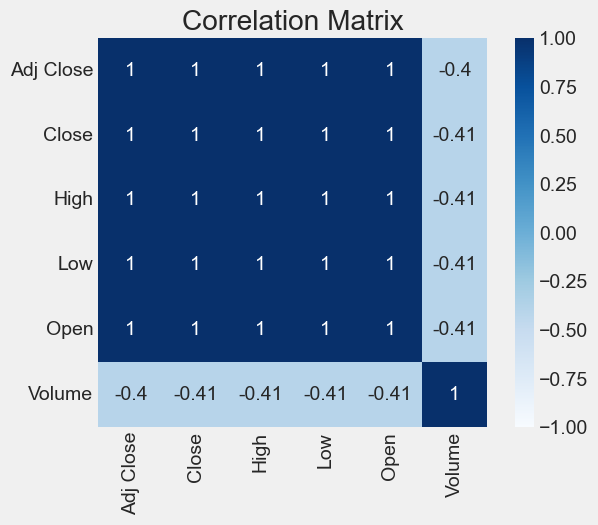

In [4]:

# draw correlation
import seaborn as sns
data_cool = data.drop(columns=['Date'])
Apple_corr = data_cool.corr()
plt.figure()

axis_corr = sns.heatmap(
Apple_corr,
vmin=-1, vmax=1, center=0,
cmap="Blues",
square=True,
annot=True
)
plt.title("Correlation Matrix")

plt.show()

In [5]:
# alpha vantage check code
#  import alpha_vantage


# from alpha_vantage.timeseries import TimeSeries
# ts = TimeSeries(key='AAPL')
# # Get json object with the intraday data and another with  the call's metadata
# data, meta_data = ts.get_intraday('AAPL',interval='15min')



# data = pd.DataFrame(data)
# print(data.T)